### Medical Insurance Costs Prediction

#### Predict medical insurance costs based on patient demographics (age, sex, bmi), number of dependents or children, region within the United States using predictive machine learning modeling.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Data
#### Data is from https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/insurance.csv

#### Data consists of
- age: age of patient
- sex: gender, female, male
- bmi: Body mass index
- children: number of children/dependents
- smoker: yes or no
- region: reside in the northeast, southeast, southwest, northwest of USA
- charges: medical costs billed by health insurance

In [2]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
print('Number of patients: ', df.shape[0])
print('Number of columns: ', df.shape[1])

Number of patients:  1338
Number of columns:  7


#### Information on data.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


#### Summary statistics of data.

Wide range in age, bmi, children and charges.

In [5]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


#### Cleaning data by removing duplicates.

In [6]:
print('Duplicated observation ', df[df.duplicated()])
df = df.drop_duplicates()
print('New number of patients: ', df.shape[0])

Duplicated observation       age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631
New number of patients:  1337


#### Distribution of data.

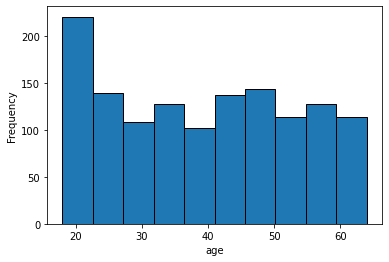

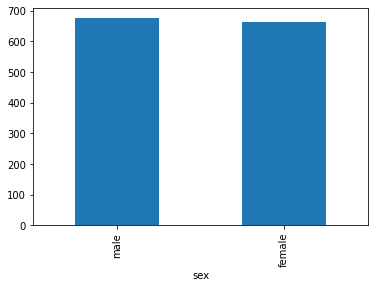

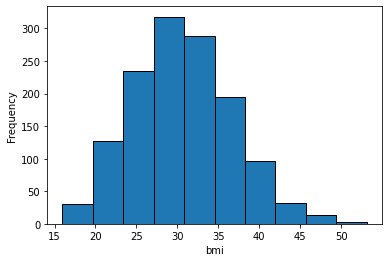

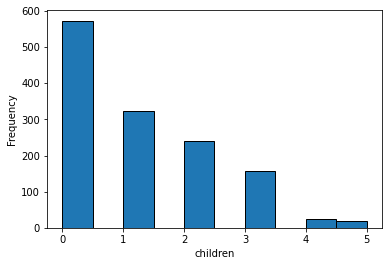

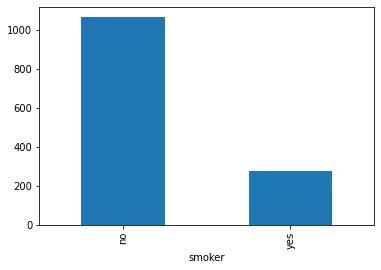

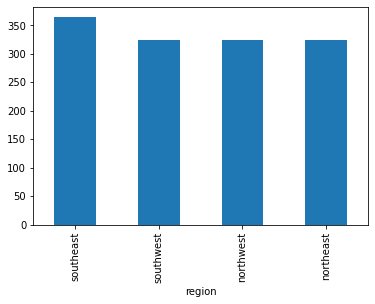

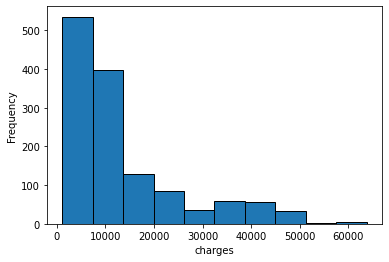

In [7]:
for column in df.columns:
    if df[column].dtypes != 'object':
        plt.figure()
        df[column].plot.hist(edgecolor = "black");
        plt.xlabel(column)
    else:
        plt.figure()
        df[column].value_counts().plot(kind='bar')
        plt.xlabel(column)

#### Visualize correlations between numerical data.

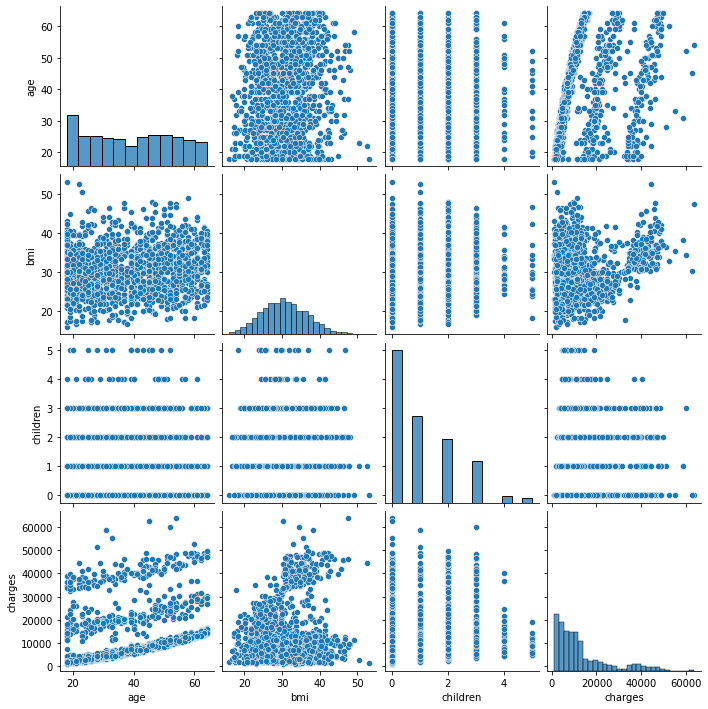

In [8]:
sns.pairplot(df);

#### Charges by sex

Similar charges for female and male.

<Figure size 432x288 with 0 Axes>

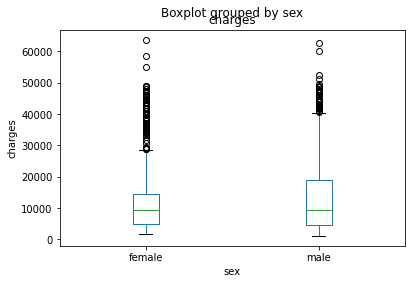

In [9]:
plt.figure();
df.boxplot(by='sex', column=['charges'], grid=False);
plt.ylabel('charges');

#### Charges by region

Similar charges by region.

<Figure size 432x288 with 0 Axes>

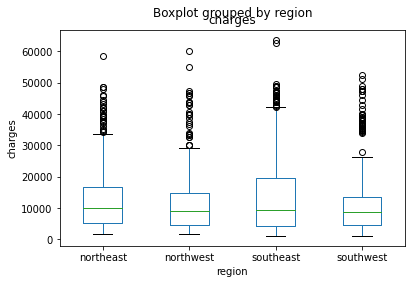

In [10]:
plt.figure();
df.boxplot(by='region', column=['charges'], grid=False);
plt.ylabel('charges');

#### Charges by smoker

Much higher charges for smoker than non-smoker.

<Figure size 432x288 with 0 Axes>

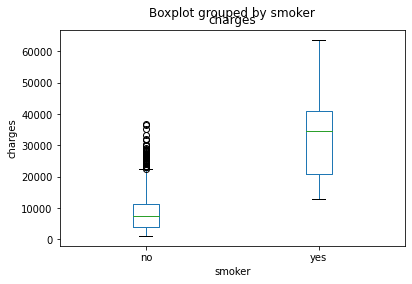

In [11]:
plt.figure();
df.boxplot(by='smoker', column=['charges'], grid=False);
plt.ylabel('charges');

#### Feature engineering.
Convert categorical features (sex, region, smoker) to nominal.

Male = 1, Female = 0

Smoker = 1, Non-smoker = 0

Represent region = 1, Do not represent region = 0

In [12]:
df_sex_smoker = pd.get_dummies(df[['sex', 'smoker']], drop_first=True)
df_sex_smoker.columns = ['gender', 'is_smoker']

df_region = pd.get_dummies(df[['region']], drop_first=False)

df_featured = pd.concat([df, df_sex_smoker, df_region], axis=1)
df_featured = df_featured.drop(['sex', 'smoker', 'region'], axis=1, errors='ignore')

#### Prediction machine learning modeling using regression.

3 models used,
1. Linear Regression
2. Ridge Regression
3. Lasso Regression

StandardScaler is used to normalized features.

PolynomialFeatures is used to create new polynomial combinations of features.

GridSearchCV is used for hyperparameter tunning of each of the 3 models.

In [13]:
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#### Metric for evaluation is root mean square error.

In [14]:
def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

#### Separate data into features and target

In [15]:
X = df_featured.drop('charges', axis=1)
y = df_featured['charges']

#### Split dataset into training and testing

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state=12345)

#### Instantiate KFold with 5 folds.

In [17]:
kf = KFold(shuffle=True, random_state=12345, n_splits=5)

#### Create Pipeline and GridSearchCV and params range for Linear Regression model

In [18]:
estimator_lr = Pipeline([("scaler", StandardScaler()),
                        ("polynomial_features", PolynomialFeatures()),
                        ("linear_regression", LinearRegression())])

params = {
    'polynomial_features__degree': [1, 2, 3]
}
grid_lr = GridSearchCV(estimator_lr, params, cv=kf)

#### Create Pipeline and GridSearchCV and params range for Ridge Regression model

In [19]:
estimator_ridge = Pipeline([("scaler", StandardScaler()),
                        ("polynomial_features", PolynomialFeatures()),
                        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(1, 80, 50)
}
grid_ridge = GridSearchCV(estimator_ridge, params, cv=kf)

#### Create Pipeline and GridSearchCV and params range for Lasso Regression model

In [20]:
estimator_lasso = Pipeline([("scaler", StandardScaler()),
                        ("polynomial_features", PolynomialFeatures()),
                        ("lasso_regression", Lasso())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'lasso_regression__alpha': np.geomspace(10, 500, 25),
    'lasso_regression__max_iter': [100000]
}
grid_lasso = GridSearchCV(estimator_lasso, params, cv=kf)

#### Run computation over all models and get RMSE for each

In [21]:
grid_list = [grid_lr, grid_ridge, grid_lasso]
model_list = ['Linear regression', 'Ridge regression', 'Lasso regression']

for model, grid in zip(model_list, grid_list):
    print(model)
    grid.fit(X_train, y_train)
    print('Best score: ', grid.best_score_)
    print('Best parameters: ', grid.best_params_)
    print('R2: ', r2_score(y_test, grid.predict(X_test)))
    print('\n')

Linear regression
Best score:  0.8313270429058314
Best parameters:  {'polynomial_features__degree': 2}
R2:  0.8560216170784641


Ridge regression
Best score:  0.8317353210701258
Best parameters:  {'polynomial_features__degree': 2, 'ridge_regression__alpha': 19.128144696681773}
R2:  0.857609253693778


Lasso regression
Best score:  0.8348821824168651
Best parameters:  {'lasso_regression__alpha': 135.7208808297453, 'lasso_regression__max_iter': 100000, 'polynomial_features__degree': 2}
R2:  0.8605858244876337




#### Best model
Lasso with largest R2, indicating best predictor for charges.

Polynomial features degree = 2
Lasso regression alpha = 135.72

#### Create best pipeline/model using tunned hyperparameters.

In [22]:
best_estimator_lasso = Pipeline([("scaler", StandardScaler()),
                        ("polynomial_features", PolynomialFeatures(degree=grid_lasso.best_params_['polynomial_features__degree'])),
                        ("lasso_regression", Lasso(alpha=grid_lasso.best_params_['lasso_regression__alpha']))])
best_estimator_lasso.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('polynomial_features', PolynomialFeatures()),
                ('lasso_regression', Lasso(alpha=135.7208808297453))])

In [23]:
print('Magnitude of Lasso coefficients:', abs(best_estimator_lasso.named_steps["lasso_regression"].coef_).sum())
print('Total number of coeffients for Lasso:', (best_estimator_lasso.named_steps["lasso_regression"].coef_).shape[0])
print('Number of coeffients not equal to 0 for Lasso:', (best_estimator_lasso.named_steps["lasso_regression"].coef_!=0).sum())

Magnitude of Lasso coefficients: 17758.892156014354
Total number of coeffients for Lasso: 55
Number of coeffients not equal to 0 for Lasso: 20


#### Rank magnitude of coefficients of Lasso regression.

In [24]:
df_importances = pd.DataFrame(zip(best_estimator_lasso.named_steps["polynomial_features"].get_feature_names_out(),
                 best_estimator_lasso.named_steps["lasso_regression"].coef_))
df_importances.sort_values(by=1)

,0,1
19,x1^2,-217.010161
4,x3,-112.878686
15,x0 x5,-83.915542
29,x2 x4,-61.167928
33,x2 x8,-42.371547
25,x1 x7,-27.833712
54,x8^2,-14.789512
36,x3 x5,-8.217561
28,x2 x3,-0.000000
30,x2 x5,0.000000


#### Compare prediction of charges with actual

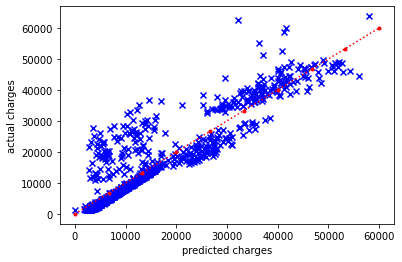

In [25]:
y_predict = best_estimator_lasso.predict(X)

max_charge = round(max(y_predict),-4)
plt.scatter(y_predict, y, marker='x', color='blue');
plt.plot(np.linspace(0, max_charge, 10), np.linspace(0, max_charge, 10), color= "red", marker='.', linestyle=':');
plt.xlabel('predicted charges');
plt.ylabel('actual charges');

#### Flaws and improvements
Medical costs is complicated with a lot of factors accounting for it beyond age, gender, bmi, number of dependents, smoking and region. 
From the exploratory analyses, smoking appears to be a strong indicator for higher costs.
But there are also other more apparent factors like occupation, pre-existing conditions, genetic predispositions, etc., which should be included to improve the prediction accuracies.

Further improvements can be with the use other regression models like Decision Trees, Random Forest Regressor, Gradient Boosted Regressor.